In [1]:
import pandas as pd
import numpy as np
import scipy.stats as stats
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from numba import njit

In [2]:
# last_price = pd.read_csv("last_price.csv", index_col='timestamp', converters={'timestamp': pd.to_datetime})
# ohlc = last_price.resample('5s', closed='right', label='right').ohlc().ffill()

In [3]:
# mid price = (best bid + best ask) / 2
# buy = sum of bid volume up to (1 - x%) * mid price
# sell = sum of ask volume up to (1 + x%) * mid price
# imbalance = buy - sell

# imbalance = pd.read_pickle('imbalance')
# imbalance = imbalance.resample('5s', closed='right', label='right').last()

In [4]:
# df = ohlc.merge(imbalance, left_on='timestamp', right_on='timestamp', how='outer')

In [5]:
df = pd.read_pickle('data')
df.iloc[:, 4:] = (df.iloc[:, 4:] - df.iloc[:, 4:].rolling(17280).mean()) / df.iloc[:, 4:].rolling(17280).std()  # 1-day rolling

In [6]:
df

,open,high,low,close,0.5%,1%,2.5%,5%,7.5%,10%,15%,20%,25%
timestamp,,,,,,,,,,,,,
2019-04-01 00:00:00,4091.0,4091.0,4091.0,4091.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-01 00:00:05,4091.0,4091.0,4091.0,4091.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-01 00:00:10,4091.0,4091.5,4089.0,4091.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-01 00:00:15,4091.0,4091.0,4090.0,4090.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-04-01 00:00:20,4090.0,4090.0,4089.5,4089.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-03-31 23:59:40,58893.0,58893.0,58875.5,58875.5,-0.414479,-1.282668,-0.744636,-0.658590,-1.182649,-1.054813,-1.268658,-1.347278,-0.935201
2021-03-31 23:59:45,58875.5,58875.5,58875.5,58875.5,-0.881235,-1.481743,-0.916459,-0.820993,-1.268724,-1.236006,-1.437244,-1.517191,-1.083445
2021-03-31 23:59:50,58876.0,58876.0,58876.0,58876.0,-0.657468,-1.395361,-0.827856,-0.737249,-1.224219,-1.142528,-1.350209,-1.429452,-1.006955


In [7]:
@njit
def predict_njit(start_equity, A, B, half_spread, max_position, X, imbalance):
    tick_size = 0.5
    running_qty = 0
    static_equity = start_equity
    fee = 0
    equity = []
    running_qty_ = []
    order_qty = 100
    new_bid = np.nan
    new_ask = np.nan
    high = 1
    low = 2
    close = 3
    #imbalance = 7
    for row in X:
        if new_bid > row[low]:
            running_qty += order_qty
            static_equity += order_qty / new_bid
            fee += order_qty / new_bid * -0.00025    
        if new_ask < row[high]:
            running_qty -= order_qty
            static_equity -= order_qty / new_ask
            fee += order_qty / new_ask * -0.00025    
        # equity.append(static_equity - running_qty / row[close] - fee)
        equity.append(static_equity * row[close] - running_qty - fee * row[close])
        running_qty_.append(running_qty)
        x = running_qty + equity[-1]
        skew = B * x / max_position * -1
        quote_mid_price = row[close] + A * row[imbalance] + skew
        new_bid = np.minimum(np.round(quote_mid_price * (1 - half_spread) / tick_size) * tick_size, row[close] - tick_size)
        new_ask = np.maximum(np.round(quote_mid_price * (1 + half_spread) / tick_size) * tick_size, row[close] + tick_size)
        if x > max_position:
            new_bid = np.nan
        if x < -max_position:
            new_ask = np.nan
    return equity, running_qty_

class Backtest:
    def __init__(self, equity=None, max_position=None, A=None, B=None, half_spread=None, imbalance=None):
        self.equity = equity
        self.max_position = max_position
        self.A = A
        self.B = B
        self.half_spread = half_spread
        self.imbalance = imbalance
        
    def set_params(self, A, B, half_spread, imbalance):
        self.A = A
        self.B = B
        self.half_spread = half_spread
        self.imbalance = imbalance
        return self
        
    def get_params(self, deep=True):
        return { 'equity': self.equity, 'max_position': self.max_position, 'A': self.A, 'B': self.B, 'half_spread': self.half_spread, 'imbalance': self.imbalance }
        
    def fit(self, X, y=None):
        return self
    
    def predict(self, X):
        equity, running_qty = predict_njit(self.equity, self.A, self.B, self.half_spread, self.max_position, X, self.imbalance)
        return equity, running_qty
    
    def score(self, X):
        equity, _ = self.predict(X)
        returns = pd.Series(equity).pct_change().fillna(0)
#         bm_returns = pd.Series(X[:, 3]).pct_change().fillna(0)
#         returns_ = returns - bm_returns
        return np.divide(returns.mean(), returns.std())

In [8]:
train = df[(df.index >= '2019-7-1') & (df.index < '2020-1-1')]
valid = df[df.index >= '2020-1-1']
# valid = df[df.index < '2020-4-1']
# train = df[df.index >= '2020-4-1']

In [9]:
#parameters = { 'A': np.linspace(0.01, 1, 100), 'B': np.linspace(0.01, 1, 100), 'half_spread': np.linspace(0.001, 0.01, 10) }
#search = GridSearchCV(Backtest(10000, 10000), parameters)
#search.fit(df)

param_dist = { 'A': stats.uniform(50, 500), 'B': stats.uniform(1, 50), 'half_spread': stats.uniform(0, 0.001), 'imbalance': np.arange(4, 13) }
search = RandomizedSearchCV(Backtest(1, 10000),
                            cv=[(np.arange(len(train)), np.arange(len(train)))],
                            param_distributions=param_dist,
                            verbose=1,
                            n_iter=1000,
                            n_jobs=8)
search.fit(train.values)

Fitting 1 folds for each of 1000 candidates, totalling 1000 fits


RandomizedSearchCV(cv=[(array([      0,       1,       2, ..., 3179517, 3179518, 3179519]),
                        array([      0,       1,       2, ..., 3179517, 3179518, 3179519]))],
                   estimator=<__main__.Backtest object at 0x7fd50e419350>,
                   n_iter=1000, n_jobs=8,
                   param_distributions={'A': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd50e419390>,
                                        'B': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd50e419450>,
                                        'half_spread': <scipy.stats._distn_infrastructure.rv_frozen object at 0x7fd547c03310>,
                                        'imbalance': array([ 4,  5,  6,  7,  8,  9, 10, 11, 12])},
                   verbose=1)

In [10]:
# v1.4 params
search.best_params_ = { 'A': 73.58892434077225, 'B': 48.80294748244207, 'half_spread': 0.0009172743599659284, 'imbalance': 11 }
search.best_estimator_.set_params(**{ 'A': 73.58892434077225, 'B': 48.80294748244207, 'half_spread': 0.0009172743599659284, 'imbalance': 11 })

In [11]:
search.best_params_

{'A': 73.58892434077225,
 'B': 48.80294748244207,
 'half_spread': 0.0009172743599659284,
 'imbalance': 11}

In [12]:
search.best_estimator_.score(train.values)

0.0031225707470001036

In [13]:
equity, running_qty = search.best_estimator_.predict(train.values)
equity = pd.Series(equity, index=train.index)
running_qty = pd.Series(running_qty, index=train.index)

<AxesSubplot:xlabel='timestamp'>

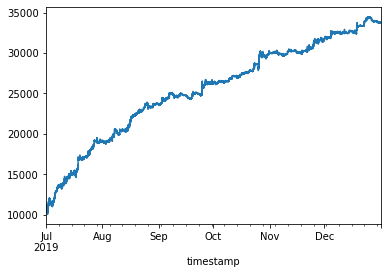

In [14]:
equity.plot()

<AxesSubplot:xlabel='timestamp'>

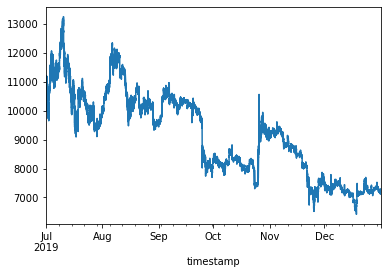

In [15]:
train["close"].plot()

<AxesSubplot:xlabel='timestamp'>

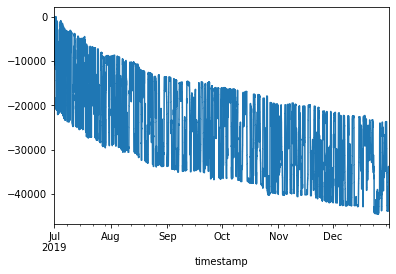

In [16]:
running_qty.plot()

Start date            2019-07-01
End date              2019-12-31
Time period (days)           183
Sharpe Ratio            5.559025
CAGR                    8.777203
Max Daily Drawdown      0.065853
dtype: object


<AxesSubplot:>

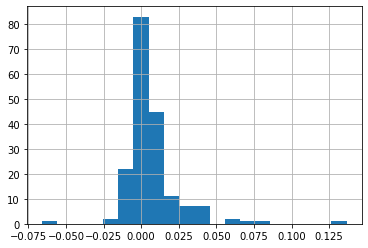

In [17]:
returns = equity.resample('1d').last().pct_change() 
bm_returns = train['close'].resample('1d').last().pct_change()
# returns_ = returns - bm_returns
returns_ = returns
sr = np.divide(returns_.mean(), returns_.std()) * np.sqrt(252)

equity_1d = equity.resample('1d').last()
Roll_Max = equity_1d.cummax()
Daily_Drawdown = np.divide(equity_1d, Roll_Max) - 1.0
Max_Daily_Drawdown = Daily_Drawdown.cummin()

period = (equity.index[-1] - equity.index[0]).days

print(pd.Series({
    'Start date': equity.index[0].strftime('%Y-%m-%d'),
    'End date': equity.index[-1].strftime('%Y-%m-%d'),
    'Time period (days)': period,
    'Sharpe Ratio': sr,
    'CAGR': (equity[-1] / equity[0]) ** (365 / period) - 1,
    'Max Daily Drawdown': -Max_Daily_Drawdown.min(),
}))

equity.resample('1d').last().pct_change().hist(bins=20)

In [18]:
equity, running_qty = search.best_estimator_.predict(valid.values)
equity = pd.Series(equity, index=valid.index)
running_qty = pd.Series(running_qty, index=valid.index)

<AxesSubplot:xlabel='timestamp'>

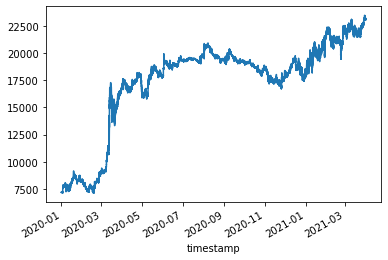

In [19]:
equity.plot()

<AxesSubplot:xlabel='timestamp'>

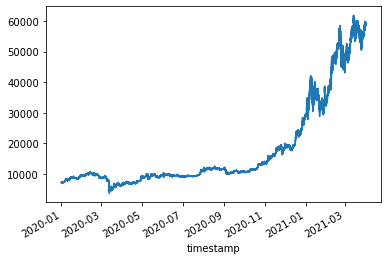

In [20]:
valid["close"].plot()

<AxesSubplot:xlabel='timestamp'>

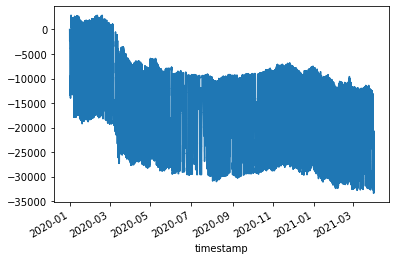

In [21]:
running_qty.plot()

Start date            2020-01-01
End date              2021-04-01
Time period (days)           456
Sharpe Ratio            1.741539
CAGR                    1.557308
Max Daily Drawdown      0.193182
dtype: object


<AxesSubplot:>

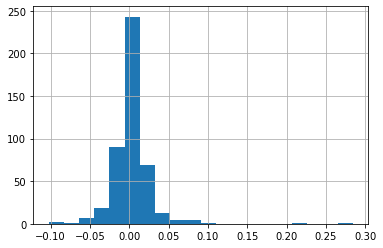

In [22]:
returns = equity.resample('1d').last().pct_change() 
bm_returns = valid['close'].resample('1d').last().pct_change()
#returns_ = returns - bm_returns
returns_ = returns
sr = np.divide(returns_.mean(), returns_.std()) * np.sqrt(252)

equity_1d = equity.resample('1d').last()
Roll_Max = equity_1d.cummax()
Daily_Drawdown = np.divide(equity_1d, Roll_Max) - 1.0
Max_Daily_Drawdown = Daily_Drawdown.cummin()

period = (equity.index[-1] - equity.index[0]).days

print(pd.Series({
    'Start date': equity.index[0].strftime('%Y-%m-%d'),
    'End date': equity.index[-1].strftime('%Y-%m-%d'),
    'Time period (days)': period,
    'Sharpe Ratio': sr,
    'CAGR': (equity[-1] / equity[0]) ** (365 / period) - 1,
    'Max Daily Drawdown': -Max_Daily_Drawdown.min(),
}))

equity.resample('1d').last().pct_change().hist(bins=20)

Start date                         2019-04-01
End date                           2021-04-01
Time period (days)                        731
Train period          2019-07-01 - 2019-12-31
Valid period          2020-01-01 - 2021-04-01
Sharpe ratio                         3.256437
CAGR                                 2.698189
RRR                                 29.898415
Maximum drawdown                     0.090245
dtype: object


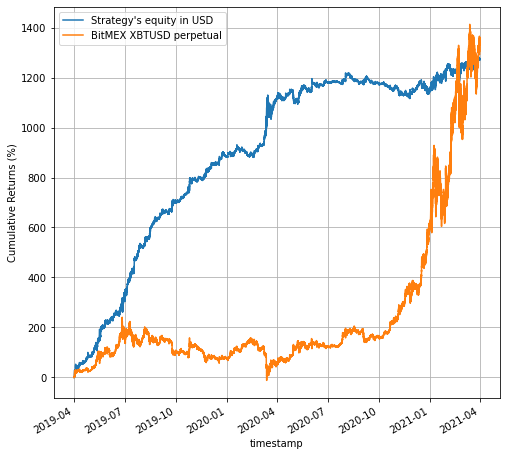

In [23]:
equity, running_qty = search.best_estimator_.predict(df.values)
equity = pd.Series(equity, index=df.index)
running_qty = pd.Series(running_qty, index=df.index)


returns = equity.resample('1d').last().pct_change() 
bm_returns = valid['close'].resample('1d').last().pct_change()
#returns_ = returns - bm_returns
returns_ = returns
sr = np.divide(returns_.mean(), returns_.std()) * np.sqrt(252)

equity_1d = equity.resample('1d').last()
Roll_Max = equity_1d.cummax()
Daily_Drawdown = np.divide(equity_1d, Roll_Max) - 1.0
Max_Daily_Drawdown = Daily_Drawdown.cummin()

period = (equity.index[-1] - equity.index[0]).days

print(pd.Series({
    'Start date': equity.index[0].strftime('%Y-%m-%d'),
    'End date': equity.index[-1].strftime('%Y-%m-%d'),
    'Time period (days)': period,
    'Train period': '%s - %s' % (train.index[0].strftime('%Y-%m-%d'), train.index[-1].strftime('%Y-%m-%d')),
    'Valid period': '%s - %s' % (valid.index[0].strftime('%Y-%m-%d'), valid.index[-1].strftime('%Y-%m-%d')),
    'Sharpe ratio': sr,
    'CAGR': (equity[-1] / equity[0]) ** (365 / period) - 1,
    'RRR': ((equity[-1] / equity[0]) ** (365 / period) - 1) / -Max_Daily_Drawdown.min(),
    'Maximum drawdown': -Max_Daily_Drawdown.min(),
}))

# equity.resample('1d').last().pct_change().hist(bins=20)

import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
ax1 = ((equity / equity[0] - 1) * 100).plot()
ax2 = ((df['close'] / df['close'][0] - 1) * 100).plot()
ax1.set_ylabel('Cumulative Returns (%)')
ax1.legend(["Strategy's equity in USD", 'BitMEX XBTUSD perpetual'])
ax1.grid()

<AxesSubplot:xlabel='timestamp'>

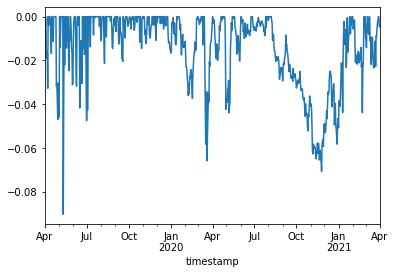

In [24]:
Daily_Drawdown.plot()